# Visualization Figures

## Imports

In [10]:
import tools.IonChainTools as ict
from tools.MSFidelityEstimation import estimateMSFidelity_errgate_allnearpairs

import matplotlib
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np

## Colormaps

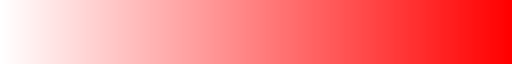

In [5]:
cdict = {'red':   [(0.0,  1.0, 1.0),
                   (1.0,  1.0, 1.0)],

         'green': [(0.0,  1.0, 1.0),
                  (1.0,  0.0, 0.0)],

         'blue':  [(0.0,  1.0, 1.0),
                   (1.0,  0.0, 0.0)]}
white2red = matplotlib.colors.LinearSegmentedColormap("white2red", cdict)
white2red

## Side-by-Side, COM vs Best, Error Gate Diagram

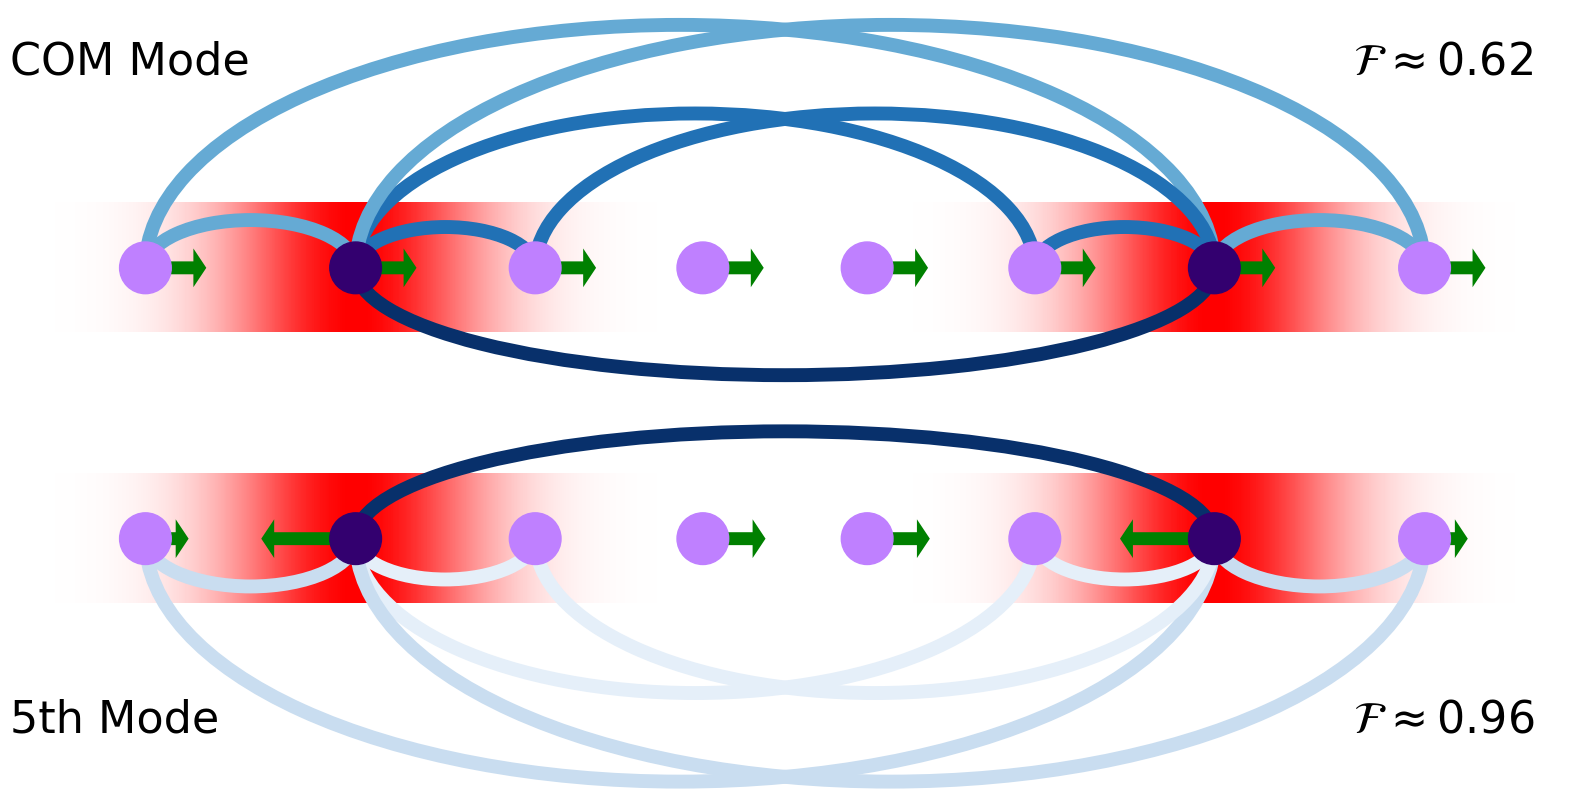

In [11]:
N = 8
m1=0
m2=4
bw = 0.7
targets = (1,6)

comfid = estimateMSFidelity_errgate_allnearpairs(N, m1, targets, bw)
bestfid = estimateMSFidelity_errgate_allnearpairs(N, m2, targets, bw)

positions = ict.calcPositions(N)
intensities = ict.calcCrosstalkIntensities(N, targets, bw)
neighbors = [a for a in range(N) if a in (targets[0]-1, targets[0]+1, targets[1]-1, targets[1]+1)] 


fig = plt.figure(figsize=(20,20))
gs = matplotlib.gridspec.GridSpec(2, 1, height_ratios=[3, 3])
ax1 = plt.subplot(gs[0, 0])
ax2 = plt.subplot(gs[1, 0])

axes = [ax1, ax2]


for ax in axes:
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    for side in ['top','bottom','left','right']:
       ax.spines[side].set_visible(False)
    ax.set_xlim(-3,3)
    ax.set_aspect('equal')

# Create beam profile
beamcenters = [positions[t] for t in targets]
position_intensities = ict.calcCrosstalkIntensitiesAtPositions(beamcenters, bw, np.linspace(-3, 3, 1000))
position_strengths = np.sqrt(position_intensities)
gradient = position_intensities.reshape(1, -1)

for m, ax in zip((m1,m2),(axes[0], axes[1])):
    if m==m1:
        ax.text(*(-3, 0.75), s="COM Mode", fontsize=32)
        ax.text(*(2.2, 0.75), s=fr"$\mathcal{'{F}'}\approx {comfid:.2f}$", fontsize=32)
        ax.set_ylim(-0.5,1)
        ax.imshow(gradient, extent=[-3, 3, -0.25, 0.25], cmap=white2red)
    else:
        ax.text(*(-3, -0.75), s=f"{m2+1}th Mode", fontsize=32)
        ax.text(*(2.2, -0.75), s=fr"$\mathcal{'{F}'}\approx {bestfid:.2f}$", fontsize=32)
        ax.set_ylim(-1,0.5)
        ax.imshow(gradient, extent=[-3, 3, -0.25, 0.25], cmap=white2red)
    arcdirection = -1 if m==m1 else 1
    # Draw Gates
    mvec = ict.calcAxialModes(N)[m][1]
    cmap = matplotlib.cm.get_cmap('Blues')
    i,j = targets
    iondistance = abs(positions[i]-positions[j])
    archeight = iondistance/4
    gatearc = patches.Arc(((positions[i]+positions[j])/2,0), abs(positions[i]-positions[j]),
                          archeight*arcdirection, theta1=0, theta2=180, lw=10, color=cmap(2.0))
    ax.add_patch(gatearc)
    for t in targets:
        for n in neighbors:
            a, b = t, n
            relspeed = abs(np.sqrt(intensities[a]*intensities[b])*mvec[a]*mvec[b])
            relspeed /= abs(np.sqrt(intensities[i]*intensities[j])*mvec[i]*mvec[j])
            #print(a,b,relspeed)
            iondistance = abs(positions[a]-positions[b])
            archeight = iondistance/2.2
            gatearc = patches.Arc(((positions[a]+positions[b])/2,0), abs(positions[a]-positions[b]),
                                  archeight*arcdirection, theta1=180, theta2=360,
                                  lw=10, color=cmap(relspeed*2))
            ax.add_patch(gatearc)


    # Draw Mode Coupling Arrows
    for i,pos in enumerate(positions):
        ax.arrow(pos,0,mvec[i]/1.5,0,width=0.05, length_includes_head=True, head_length=0.05,
                lw=0, color='green')
             
    # Draw Ions
    for i,pos in enumerate(positions):
        color = (51/255, 0, 111/255) if i in targets else (0.75,0.50,1.00)
        ion = patches.Circle((pos,0), 0.1, color=color)
        ax.add_patch(ion)
        
fig.subplots_adjust(wspace=0, hspace=0, top=0.4, bottom=0)

plt.show()

## Crosstalk vs Chain Length

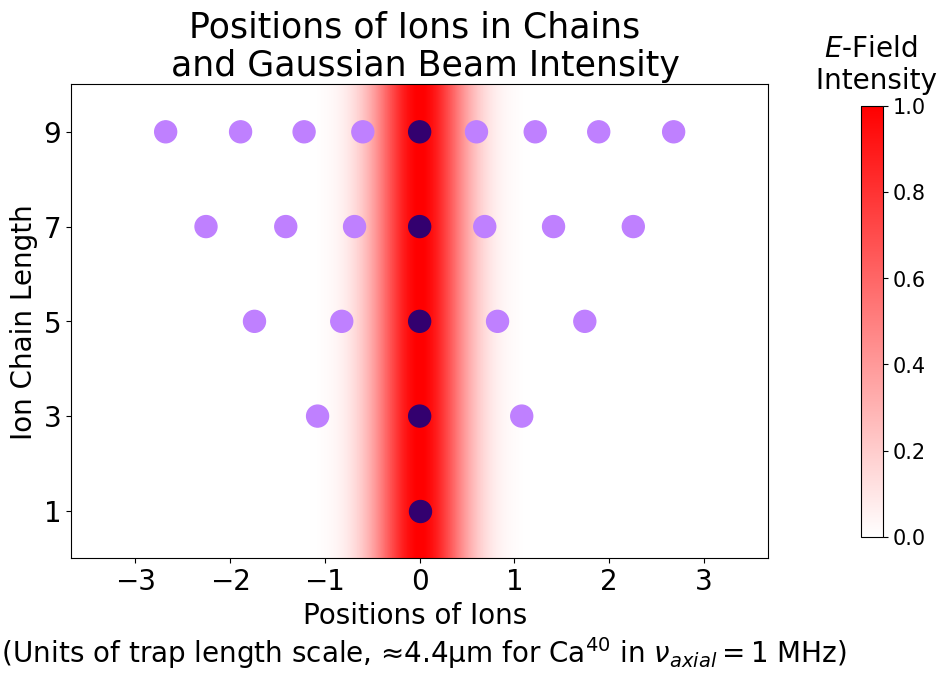

In [13]:
Nrange = np.arange(1, 11, 2)
fig, ax = plt.subplots(figsize=(12, 8))
for N in Nrange:
    positions = ict.calcPositions(N)
    c = [(51/255, 0, 111/255) if i==(N-1)/2 else (0.75,0.50,1.00) for i in range(N)]
    ax.scatter(positions, np.ones(N)*N, c=c, s=250)
beamcenters = [0]
bw=0.7
intensities = ict.calcCrosstalkIntensitiesAtPositions(beamcenters, bw, np.linspace(positions[0]-1, positions[-1]+1, 1000))
strengths = np.sqrt(intensities)
gradient = intensities.reshape(1, -1)
mappable = ax.imshow(gradient, extent=[positions[0]-1, positions[-1]+1, 0, 10],
                     aspect=0.5, cmap=white2red, vmin=0, vmax=1)
cbar = fig.colorbar(mappable, location='right', orientation='vertical', shrink=0.7, pad=0.1)
cbar.ax.set_title(label='$E$-Field \n Intensity', size=20, y=1.02)
cbar.ax.tick_params(labelsize=15)
ax.tick_params(labelsize=20)
ax.set_yticks(np.arange(1,11,2))
ax.set_title('Positions of Ions in Chains \n and Gaussian Beam Intensity', fontsize=25)
ax.set_xlabel('Positions of Ions \n (Units of trap length scale, ≈4.4μm for Ca$^{40}$ in $ν_{axial} = 1$ MHz)',
             fontsize=20)
ax.set_ylabel('Ion Chain Length', fontsize=20);

## Axial and Radial Mode Spectrum

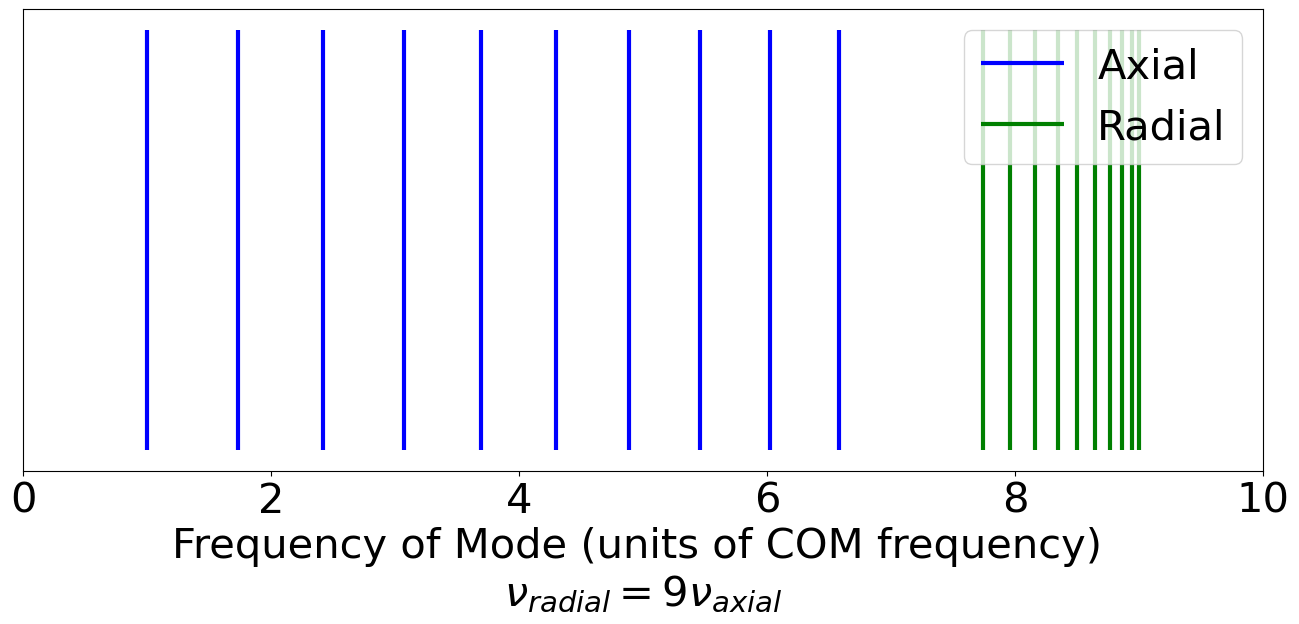

In [15]:
N=10
axialmodes = ict.calcAxialModes(N)
radialmodes = ict.calcRadialModes(N, νratio=9)
axialfreqs = [axialmodes[m][0] for m in range(N)]
radialfreqs = [radialmodes[m][0] for m in range(N)]
fig, ax = plt.subplots(figsize=(16,6))
ax.set_xlim(0, 10)
ax.get_yaxis().set_visible(False)
ax.vlines(axialfreqs, ymin=0, ymax=1, label="Axial", color="blue", lw=3)
ax.vlines(radialfreqs, ymin=0, ymax=1, label="Radial", color="green", lw=3)
ax.set_xlabel("Frequency of Mode (units of COM frequency) \n"r"$\nu_{radial} = 9\nu_{axial}$", fontsize=30)
ax.legend(fontsize=30)
ax.tick_params(labelsize=30)